# Project : 뉴스기사 요약해보기

## Step 1. 실험환경 Set-up

### 1-1. Set

In [1]:
# 패키지 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


### 1-2. Data load

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH) # 주어진 패턴과 일치하는 파일 목록을 반환합니다.
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1512_bacteria_3958.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person357_bacteria_1639.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

Normal images count in training set: 1078
Pneumonia images count in training set: 3107


In [7]:
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 
# 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지의 사이즈를 통일 시키고 ,
# GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
# num_parallel_calls 파라미터에서 
# set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터셋도 만들어 보겠습니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# 좌우 반전 정도의 augmentation
# augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 1-3. Data Visualization

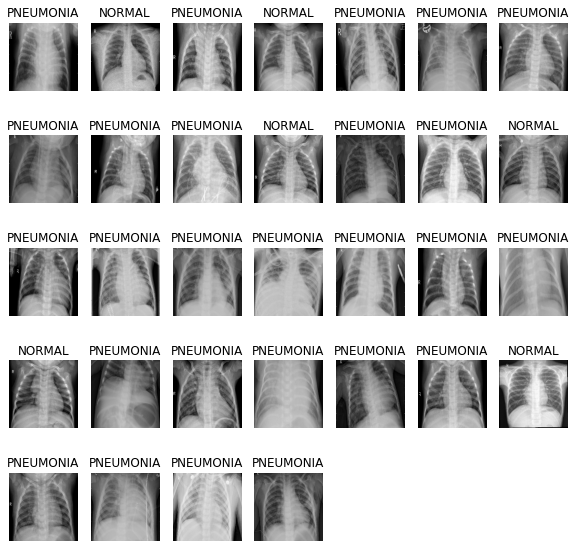

In [15]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 1-4. CNN Modeling

#### 1-4-1. Only Batch Normalization

In [21]:
# 먼저, Convolution block을 만듭니다.
# conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 
# Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

def conv_block_batch(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [22]:
def dense_block_batch(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [23]:
def build_model_batch():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_batch(32),
        conv_block_batch(64),
        
        conv_block_batch(128),
        
        conv_block_batch(256),
        
        tf.keras.layers.Flatten(),
        dense_block_batch(512, 0.7),
        dense_block_batch(128, 0.5),
        dense_block_batch(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 1-4-2. Only Dropout

In [29]:
def conv_block_do(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [30]:
def dense_block_do(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [31]:
def build_model_do():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_do(32),
        conv_block_do(64),
        
        conv_block_do(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_do(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_do(512, 0.7),
        dense_block_do(128, 0.5),
        dense_block_do(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### 1-4-3. Original(Data Augmentation + Batch Normalization + Dropout)

In [36]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 1-5. 데이터 imbalance 처리

In [24]:
# 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 
# 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.
# 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.
# Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 
# 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.
# Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 
# 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

# 'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# 'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 1-6. Model Training

#### 1-6-1. Model(Only Batch Normalization)

In [25]:
# 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 
# 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.
# 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. 
# optimizer로 'adam'을 사용합니다.
# metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

with tf.device('/GPU:0'):
    model = build_model_batch()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
130/130 [==============================] - 52s 261ms/step - loss: 0.2728 - accuracy: 0.8716 - precision: 0.9736 - recall: 0.8495 - val_loss: 0.6695 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/50
130/130 [==============================] - 33s 250ms/step - loss: 0.1459 - accuracy: 0.9459 - precision: 0.9813 - recall: 0.9448 - val_loss: 0.6524 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/50
130/130 [==============================] - 32s 250ms/step - loss: 0.1109 - accuracy: 0.9598 - precision: 0.9850 - recall: 0.9612 - val_loss: 0.7676 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/50
130/130 [==============================] - 33s 251ms/step - loss: 0.1040 - accuracy: 0.9621 - precision: 0.9887 - recall: 0.9601 - val_loss: 1.1479 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/50
130/130 [==============================] - 33s 251ms/step - loss: 0.0877 - accura

#### 1-6-2. Model(Only Dropout)

In [32]:
with tf.device('/GPU:0'):
    model2 = build_model_do()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
130/130 [==============================] - 40s 258ms/step - loss: 0.5326 - accuracy: 0.7247 - precision: 0.8533 - recall: 0.7609 - val_loss: 0.5920 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/50
130/130 [==============================] - 32s 249ms/step - loss: 0.2307 - accuracy: 0.8981 - precision: 0.9800 - recall: 0.8822 - val_loss: 0.7728 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/50
130/130 [==============================] - 32s 248ms/step - loss: 0.1702 - accuracy: 0.9352 - precision: 0.9789 - recall: 0.9322 - val_loss: 0.9901 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/50
130/130 [==============================] - 32s 249ms/step - loss: 0.1411 - accuracy: 0.9471 - precision: 0.9862 - recall: 0.9420 - val_loss: 0.8299 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/50
130/130 [==============================] - 32s 249ms/step - loss: 0.1448 - accura

#### 1-6-3. Original(Data Augmentation + Batch Normalization + Dropout)

In [39]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
130/130 [==============================] - 41s 259ms/step - loss: 0.4860 - accuracy: 0.7300 - precision: 0.9295 - recall: 0.6923 - val_loss: 0.6094 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/50
130/130 [==============================] - 33s 252ms/step - loss: 0.2329 - accuracy: 0.9128 - precision: 0.9697 - recall: 0.9099 - val_loss: 0.7789 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 3/50
130/130 [==============================] - 33s 251ms/step - loss: 0.1731 - accuracy: 0.9324 - precision: 0.9803 - recall: 0.9277 - val_loss: 1.0401 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/50
130/130 [==============================] - 33s 253ms/step - loss: 0.1320 - accuracy: 0.9513 - precision: 0.9837 - recall: 0.9506 - val_loss: 1.3477 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 5/50
130/130 [==============================] - 33s 252ms/step - loss: 0.1320 - accura

### 1-7. 결과확인

#### 1-7-1. 결과(Only Batch Normalization)

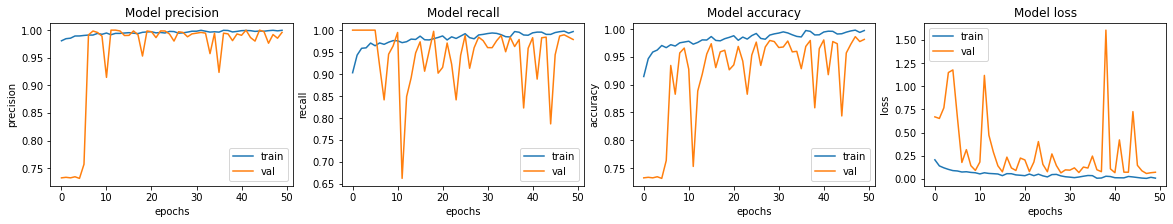

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 9s 471ms/step - loss: 1.5992 - accuracy: 0.7772 - precision: 0.7381 - recall: 0.9974
Loss: 1.5991580486297607,
Accuracy: 0.7772436141967773,
Precision: 0.7381404042243958,
Recall: 0.9974358677864075


#### 1-7-2. 결과(Only Dropout)

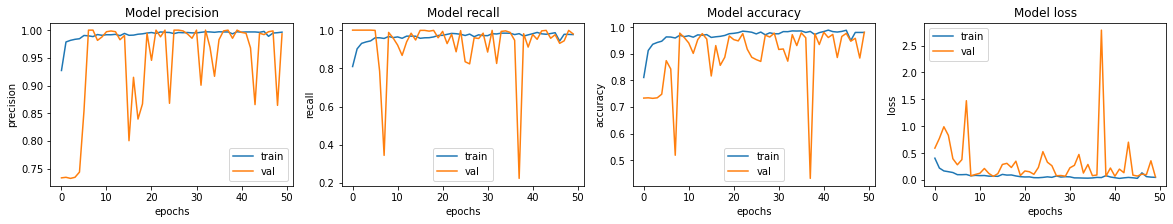

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 3s 139ms/step - loss: 2.7203 - accuracy: 0.7724 - precision: 0.7340 - recall: 0.9974
Loss: 2.720294713973999,
Accuracy: 0.7724359035491943,
Precision: 0.7339622378349304,
Recall: 0.9974358677864075


#### 1-7-2. 결과Original(data augmentation)

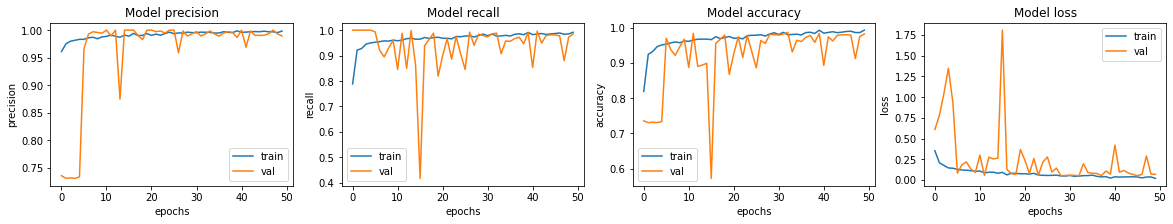

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
# 테스트 데이터로 모델 평가를 해보겠습니다.

loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 3s 139ms/step - loss: 1.2691 - accuracy: 0.8173 - precision: 0.7794 - recall: 0.9872
Loss: 1.2691495418548584,
Accuracy: 0.817307710647583,
Precision: 0.7793522477149963,
Recall: 0.9871794581413269


## Step 2. 결과비교

- Data Augmentation + Batch Normalization
    - Accuracy: 0.7772436141967773

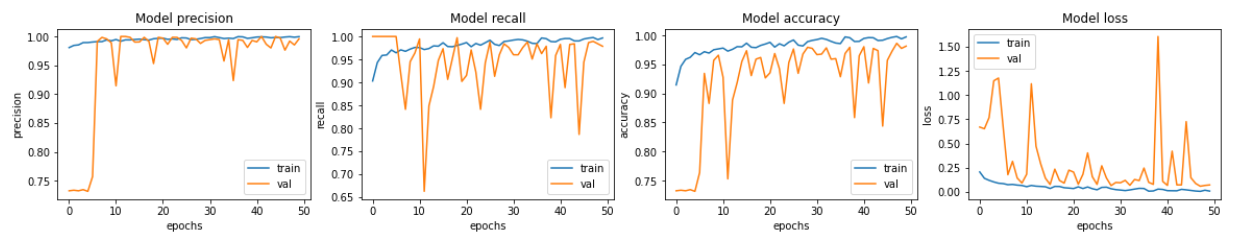

- Data Augmentation + Dropout
    - Accuracy: 0.7724359035491943

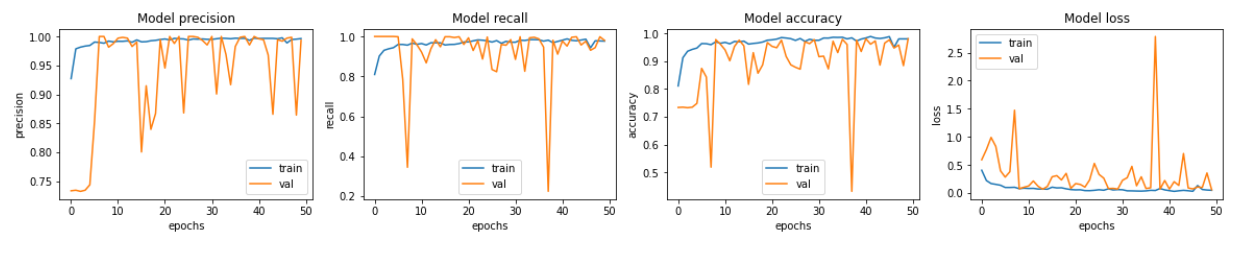

- Data Augmentation + Batch Normalization + Dropout
    - Accuracy: 0.817307710647583

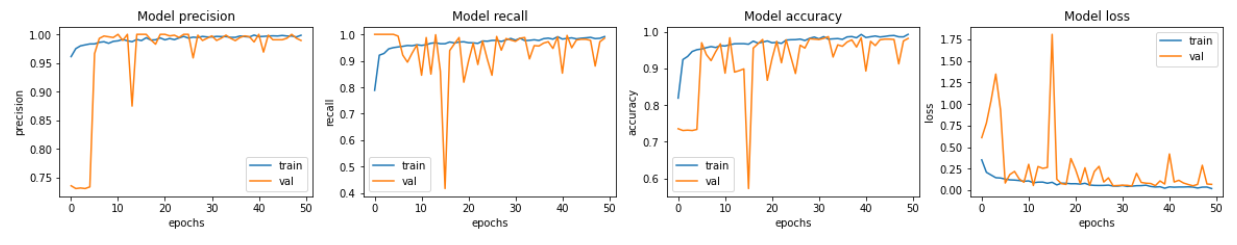

### 회고

- Data Augmentation + Batch Normalization + Dropout 상태에서 Batch Normalization, Dropout을 개별적으로 사용했을 때 상대적으로 낮은 정확도의 결과값이 나왔다.
- 결과값을 높이기 위해 BATCH_SIZE, EPOCHS 를 16, 25에서 32, 50으로 늘려 학습시켜 보았다.
- 결과적으로 정확도는 0.817 이상으로 나오지 못했다.